# Trabalho Visão Computacional Parte 2.1

- Diego Pavan Soler    NUSP: 4607661
- José Luiz Maciel Pimenta NUSP: 11896720
- Luis Ricardo Manrique NUSP: 5779294

# 1 - Introdução

## Compartilhamento do Projeto
- Git: https://github.com/JoseLuiz432/MAC5768.git
- Drive: https://drive.google.com/drive/folders/1bvwXFjPWP-Sdb5Lwh6zFd_vQs24mJ6_c?usp=sharing


# 2 - Objetivos

Aumentar a base de dados utilizando uma técnica conhecida como *Data Augmentation*. Cada uma das funções de *Data Augmentation* foram aplicadas nas imagens na base de dados em níveis de cinza. Portanto, o primeiro passo foi converter as imagens da base de dados em níveis de cinza. Essas imagens foram colocadas no drive na pasta '/dataset/augmentation/originalGrayDataset/'.

Após essa converção, as seguinte funções foram utilizadas, seguidas de seus respectivos diretorios:
- Soma de fundo com gradiente de níveis de cinza: '/dataset/augmentation/augmentedDataset/gradient/'
- Logaritmo da imagem: '/dataset/augmentation/augmentedDataset/log/'
- Exponencial da imagem: '/dataset/augmentation/augmentedDataset/exp/'
- Filtro da média implementado usando convolução: '/dataset/augmentation/augmentedDataset/mean/'




# 3 - Desenvolvimento 

## 3.1 - Ambiente de Trabalho

Este notebook foi desenvolvido no Google Colab. Assim, aproveitamos o fato de poder acessar o Google Drive diretamente. Contudo, para que isso seja possível é necessário ter acesso a pasta "Trabalho_Visão" (Link do Drive em 1), criar um atalho, desta pasta, no diretorio raiz do Drive ("/content/gdrive/My_Drive") e, por fim, executar o código abaixo para que o Colab tenha acesso ao seu Drive:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Após uma motagem do Drive ser bem sucedida, é necessário mudar o diretório de trabalho para a pasta "Trabalho_Visão". Isso é feito executando a celula abaixo:

In [2]:
import os
os.chdir('/content/gdrive/My Drive/Trabalho_Visao')

Para este trabalho utilizamos algumas bibliotecas, como o scikit-image. Para 

1.   Item da lista
2.   Item da lista

instalar essas bibliotecas é necessário executar a célula abaixo.

In [ ]:
! python -m pip install -U scikit-image

In [4]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import pandas as pd

Carregar os metadados das imagens utilizadas

In [5]:
df = pd.read_csv('dataset/dataset.csv')

Função utilizada para criar os novos metadados das imagens após a realização da operação sobre elas

In [6]:
def create_new_images(path_read, path_write, path_df, create_func, date):
  """ Criação de novas imagens utilizando imagens existentes modificando-as 
  utilizando a função passada. Retorna os metadados das novas imagens

  Keyword arguments:
  path_read   --  diretorio das imagens de entrada
  path_write  -- diretorio das imagens de saida
  path_df     -- diretorio a ser salvo no novo metadados
  create_func -- função de modificação da imagem: create_func(np.array) -> np.array 
  date        -- data a ser colocado no metadados

  create_new_images(str, str, str, func, str) -> str
  """
  new_df = "DIR\tDATE\tCLASS_NAME\tOBJ_ID\tBACKGROUND\tLIGHT\tINDOOR\n"
  for row in df.iterrows():
    row = row[1]
    fname = row['DIR']
    fname_df = path_df % fname
    fname_wirte = path_write % fname
    img = path_read + row['DIR']
    img = io.imread(img)
    nw_img = create_func(img)
    nw_img = nw_img.astype(np.uint8)
    
    io.imsave(fname_wirte, nw_img)
    new_df += "%s\t%s\t%s\t%s\t%s\t%s\t%s\n" %(
        fname_df, date, row['CLASS_NAME'], 
        row['OBJ_ID'], row['BACKGROUND'],
        row['LIGHT'],row['INDOOR'])
  
  return new_df

## 3.1 - RGBTOGRAY

Nesta seção foi calculado a conversão da imagem em RGB para níveis de cinza. Essa converção segue a formula abaixo:

$c_{ij} = 0.2125 * a_{ij1} + 0.7154*a_{ij2} + 0.0721* a_{ij3}$

Para $1 \leq i \leq M$ e $1 \leq j \leq N$. Sendo M o número de linhas da matriz $A$ e N o número de colunas.   


In [ ]:
# Conversão de RGB para escala de cinza
# Considerando: # Gray = 0.2125 * R + 0.7154 * G + 0.0721 * B
def rgbTOOgray(image):
    """Conversão de RGB para escala de cinza, seguindo o padrao:
    Gray = 0.2125 * R + 0.7154 * G + 0.0721 * B

    Keyword arguments:
    imagem -- imagem de entrada no formato RGB

     rgbTOOgray(np.array) -> np.array
    """
    return np.dot(image[...,:3], [0.2125, 0.7154, 0.0721]) / 255

In [ ]:
path = 'dataset/augmentation/originalGrayDataset/%s'
path2 = '/augmentation/originalGrayDataset/%s'

new_df = create_new_images('dataset/augmentation/originalGrayDataset/',
                           path, path2, gradient_mask, "15-11-2020")
  
arquivo = open('gray_dataset.csv', 'w')
arquivo.write(new_df)
arquivo.close()

### Exemplo RGBTOGRAY

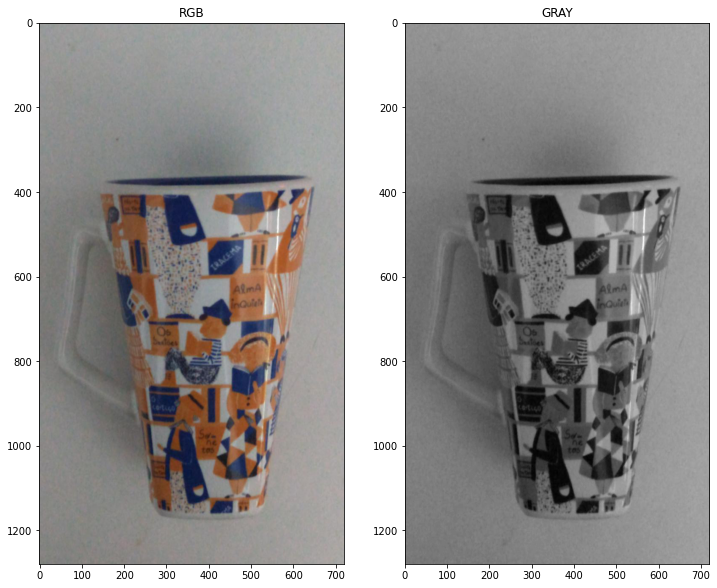

In [8]:
img_gray = io.imread('dataset/augmentation/originalGrayDataset/Caneca/Caneca-136.jpg')
img_rgb = io.imread('dataset/Caneca/Caneca-136.jpg')
fig, axarr = plt.subplots(1,2, figsize=(12,12))
axarr[0].set_title('RGB')
axarr[1].set_title('GRAY')
axarr[0].imshow(img_rgb)
axarr[1].imshow(img_gray, cmap='gray')

## 3.2 - Gradiente

Nesta seção foi calculado a multiplicação entre a imagem em níveis de cinza com o gradiente. Para resolver a saturação a imagem de entrada foi divida por 255 fazendo com que o intervalo ficasse entre [0,1] e então a multiplicação por um gradiente com o intervalo [0, 255] não cause saturação.

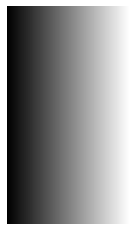

In [32]:
# Soma de fundo com gradiente de níveis de cinza
def gradient_mask(image, return_mask = False):
    """Aplica mascara de gradiente na imagem. Para visualizar a mascara, return_mask = True

    Keyword arguments:
    imagem -- imagem de entrada em tons de cinza
    return_mask -- Retorna também a mascara para visualização

    gradient_mask(np.array) -> np.array
    """
    image = image / 255
    height, width = image.shape
    x = np.linspace(-np.pi,np.pi, width)
    
    sine1D = np.uint8(width / 2 + (width / 4 * np.sin(x * 0.1)))
    sine2D = np.tile((sine1D), (height,1))
    
    if return_mask:
      return image * sine2D, sine2D
    else: 
      return image * sine2D

# Filtro de gradiente utilizado:
img_gray = io.imread('dataset/augmentation/originalGrayDataset/Caneca/Caneca-136.jpg')
img, sine2D = gradient_mask(img_gray, return_mask = True)
plt.axis('off')
plt.imshow(sine2D, cmap='gray')

In [ ]:
path = 'dataset/augmentation/augmentedDataset/gradient/%s'
path2 = '/augmentation/augmentedDataset/gradient/%s'

new_df = create_new_images('dataset/augmentation/originalGrayDataset/',
                           path, path2, gradient_mask, "15-11-2020")
  
arquivo = open('gradient_dataset.csv', 'w')
arquivo.write(new_df)
arquivo.close()

### Exemplo Gradiente

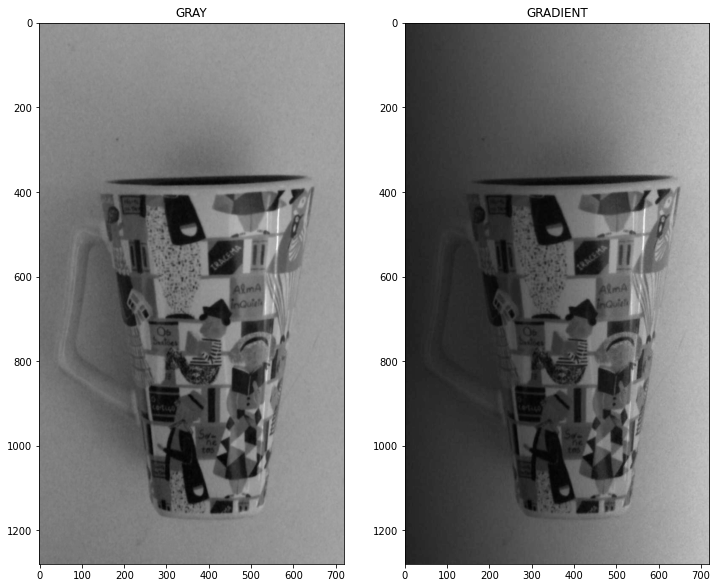

In [9]:
img_grad = io.imread('dataset/augmentation/augmentedDataset/gradient/Caneca/Caneca-136.jpg')
img_gray = io.imread('dataset/augmentation/originalGrayDataset/Caneca/Caneca-136.jpg')
fig, axarr = plt.subplots(1,2, figsize=(12,12))
axarr[0].set_title('GRAY')
axarr[1].set_title('GRADIENT')
axarr[0].imshow(img_gray, cmap='gray')
axarr[1].imshow(img_grad, cmap='gray')

## 3.3 - Filtro da Média
Nesta seção foi feita a operação do filtro da média sobre a imagem em níveis de cinza. Essa operação foi realizada utilizando a convolução.

In [ ]:
def convolucao(imagem, k_size=(15, 15), pesos=1, passo=1, padding=True, filtro='media'):
    """Realiza a convolução na imagem.

    Keyword arguments:
    imagem -- imagem de entrada em tons de cinza
    k_size -- tamanho do kernel (default=(15, 15))
    pesos  -- peso para cada posicao (default=1)
    passo  -- passo da convolucao (default=1)
    padding-- adicionar padding a imagem (default=True) 

    convolucao(np.array) -> np.array
    """
    
    n_lins, n_cols = imagem.shape
    div_aux = k_size[0] * k_size[1] 
    t = k_size[0] // 2
    if padding:
      imagem = np.pad(imagem, (t, t), 'constant', constant_values=(0, 0))
      nova_imagem = np.zeros((n_lins, n_cols))
    else:
      nl, nc = k_size.shape
      nova_imagem = np.zeros(((n_lins - nl)//passo +1, (n_cols - nc)//passo +1))
    
    mask = 1
    if filtro == 'media':
      mask = np.full(k_size, 1/(k_size[0]*k_size[1]))   
      mask = mask * pesos
      
    for x in range(t, n_lins+t, passo):
      for y in range(t, n_cols+t, passo):
        nova_imagem[(x-t)//passo,(y-t)//passo] = np.sum(imagem[x-t:x+t+1, y-t:y+t+1] * mask)
    
    return nova_imagem

In [ ]:
path = 'dataset/augmentation/augmentedDataset/mean/%s'
path2 = '/augmentation/augmentedDataset/mean/%s'

new_df = create_new_images('dataset/augmentation/originalGrayDataset/',
                           path, path2, convolucao, "15-11-2020")
  
arquivo = open('mean_dataset.csv', 'w')
arquivo.write(new_df)
arquivo.close()

### Exemplo filtro da média

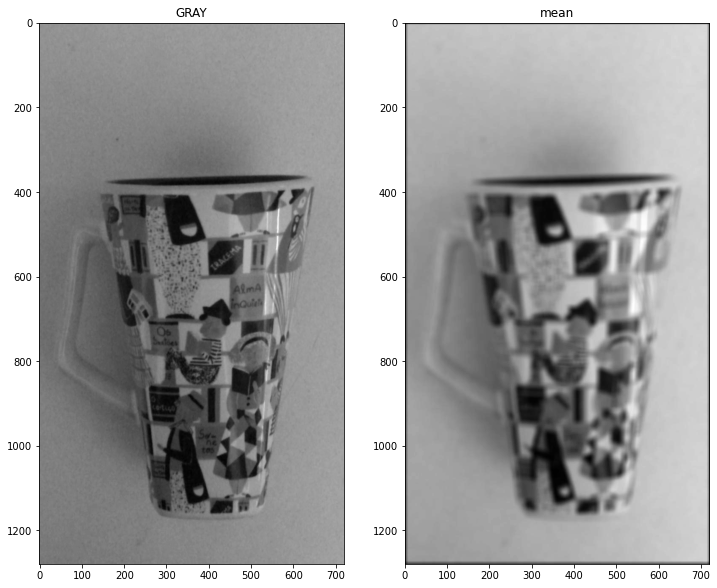

In [33]:
img_mean = io.imread('dataset/augmentation/augmentedDataset/mean/Caneca/Caneca-136.jpg')
img_gray = io.imread('dataset/augmentation/originalGrayDataset/Caneca/Caneca-136.jpg')
fig, axarr = plt.subplots(1,2, figsize=(12,12))
axarr[0].set_title('GRAY')
axarr[1].set_title('mean')
axarr[0].imshow(img_gray, cmap='gray')
axarr[1].imshow(img_mean, cmap='gray')

## 3.4 - Filtro da Logaritmo da imagem

A transformação logarítmica aplica é a: s = c log (1 + r) onde c é uma constante e considera-se que r ≥ 0. 
Essa transformação mapeia uma faixa estreita de baixos valores de intensidade de entrada em uma faixa mais ampla de níveis de saída. O oposto se aplica aos valores mais altos de níveis de intensidade de entrada. Utilizamos uma transformação desse tipo para expandir os valores de pixels mais escuros em uma imagem ao mesmo tempo em que comprimimos os valores de nível mais alto. O oposto se aplica à transformação logarítmica inversa (exp).

In [ ]:
def log_filter(image, c=1):
    """Executa a aplicacao do filtro log na imagem de entrada.
    A funcao utilizada para a correcao esta de acordo com a equacao
    ``O = c*log(1 + I)``, extraida de Gonzalez RC, Woods RE (2008) Digital 
    image processing. Prentice Hall, Englewood Cliffs. Alem da aplicacao da
    equacao, o intervalo dos pixels da imagem eh mudado para [0..1].
    
    
    Keyword arguments:
    image -- imagem de entrada no formato Grayscale
    c -- constante multiplicadora, valor padrao eh 1

    log_filter(np.array, [c=int]) -> np.array
    """
    scale = float(np.max(image) - np.min(image))
    return np.log2(1 + image / scale) * scale * c

In [ ]:
output_log = "dataset/augmentation/augmentedDataset/log/"
output_log_df = "augmentation/augmentedDataset/log/"
df_log = create_new_images('dataset/augmentation/originalGrayDataset/',
                           output_log, output_log_df, log_filter, "15-11-2020")

arquivo_log = open('dataset/log_dataset.csv', 'w')
arquivo_log.write(df_log)
arquivo_log.close()

### Exemplo logaritmo da imagem

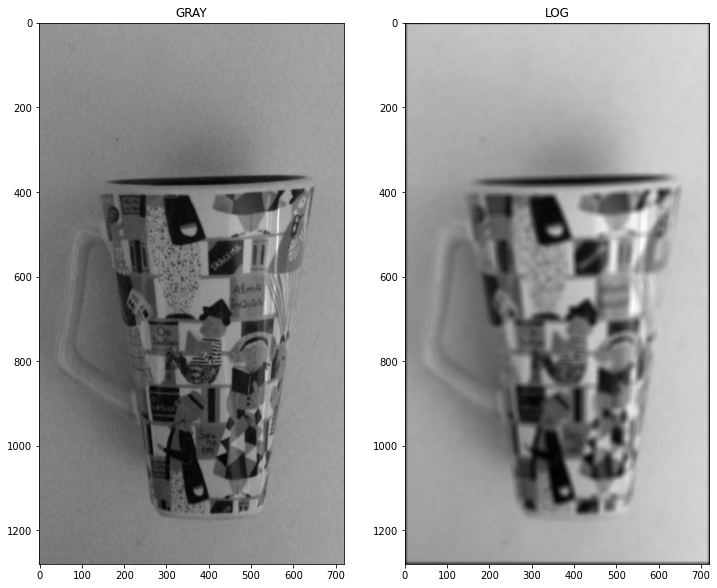

In [34]:
img_log = io.imread('dataset/augmentation/augmentedDataset/log/Caneca/Caneca-136.jpg')
img_gray = io.imread('dataset/augmentation/originalGrayDataset/Caneca/Caneca-136.jpg')
fig, axarr = plt.subplots(1,2, figsize=(12,12))
axarr[0].set_title('GRAY')
axarr[1].set_title('LOG')
axarr[0].imshow(img_gray, cmap='gray')
axarr[1].imshow(img_mean, cmap='gray')

## 3.5 - Filtro da Exponencial da imagem

In [ ]:
def exp_filter(image, c=1):
    """Executa a aplicacao do filtro exp (log inverso) na imagem de entrada.
    A funcao utilizada para a correcao esta de acordo com a equacao
    ``O = c*(2**I - 1)``, extraida de Gonzalez RC, Woods RE (2008) Digital 
    image processing. Prentice Hall, Englewood Cliffs. Alem da aplicacao da
    equacao, o intervalo dos pixels da imagem eh mudado para [0..1].
    
    
    Keyword arguments:
    image -- imagem de entrada no formato Grayscale
    c -- constante multiplicadora, valor padrao eh 1

    exp_filter(np.array, [c=int]) -> np.array
    """
    scale = float(np.max(image) - np.min(image))
    return (2 ** (image / scale) - 1) * scale * c

In [ ]:
output_exp = "dataset/augmentation/augmentedDataset/exp/"
output_exp_df = "augmentation/augmentedDataset/exp/"
df_exp = create_new_images('dataset/augmentation/originalGrayDataset/',
                           output_exp, output_exp_df, exp_filter, "15-11-2020")

arquivo_exp = open('dataset/log_dataset.csv', 'w')
arquivo_exp.write(df_exp)
arquivo_exp.close()

### Exemplo exponencial da imagem

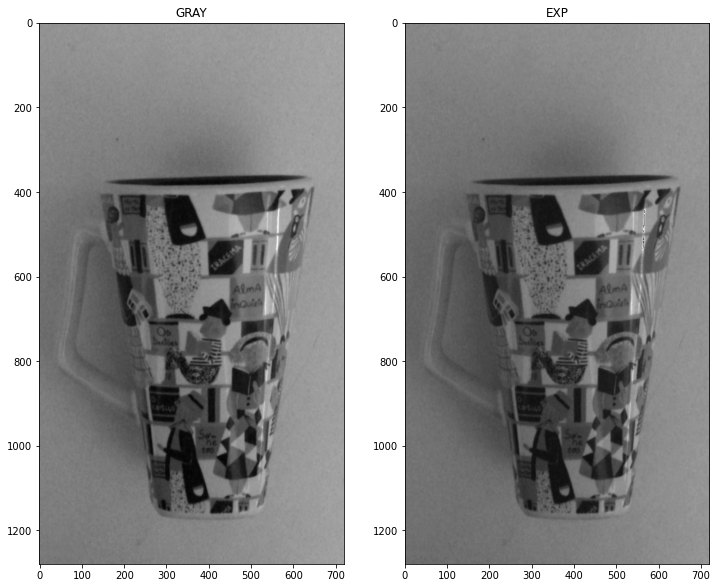

In [35]:
img_exp = io.imread('dataset/augmentation/augmentedDataset/exp/Caneca/Caneca-136.jpg')
img_gray = io.imread('dataset/augmentation/originalGrayDataset/Caneca/Caneca-136.jpg')
fig, axarr = plt.subplots(1,2, figsize=(12,12))
axarr[0].set_title('GRAY')
axarr[1].set_title('EXP')
axarr[0].imshow(img_gray, cmap='gray')
axarr[1].imshow(img_exp, cmap='gray')